# Individual Proyect PVLIB
## SIMULATION AND OPTIMIZATION SOFTWARE FOR PHOTOVOLTAIC SYSTEMS
## Martín Francisco Martín Ruiz

# 1. Nominal Power of the plant

Se va a realizar una instalación solar conectada a red en una casa rural en Salobreña (Granada). La cubierta del edificio tiene unas dimensiones de 6mx14m = 84 m2. Por tanto suponiendo que el área utilizable son de 70 m2, la eficiencia entorno al 18% y una G de 1000 W/m2 se puede hacer una primera aproximación para una instalación de 12 kW.

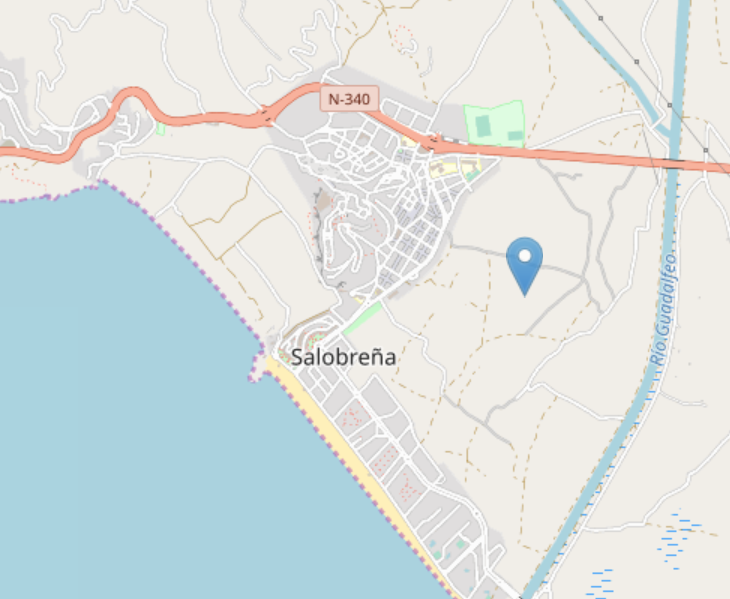


# 2. Location TMY


In [1]:
import os  # for getting environment variables 

import pathlib  # for finding the example dataset 

import pvlib 

import pandas as pd  # for data wrangling 

import matplotlib.pyplot as plt  # for visualization 

## **- Document the name and type of the solar resource database that was used to build the TMY file**


In [2]:
# Location coordinates are selected
latitude = 36.735
longitude = -3.577
altitude = 6

In [3]:
# Obtain TMY data from PVGIS. map_variables renamed irradiance parameters to ghi, dni and dhi.
Location_TMY = pvlib.iotools.get_pvgis_tmy(latitude, longitude, outputformat='json', usehorizon=True, startyear=2006,
                                           endyear=2016,map_variables = True, url='https://re.jrc.ec.europa.eu/api/', timeout=30)

In [4]:
# Keep dataframe and show some rows of it.
Location_TMY_df = Location_TMY[0]
Location_TMY_df.index = [ts.replace(year=2022) for ts in Location_TMY_df.index]
Location_TMY_df.head()

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
2022-01-01 00:00:00+00:00,14.85,97.13,0.0,0.0,0.0,328.37,5.96,278.0,102151.0
2022-01-01 01:00:00+00:00,14.50,97.85,0.0,0.0,0.0,332.70,6.62,276.0,102104.0
2022-01-01 02:00:00+00:00,14.15,98.57,0.0,0.0,0.0,337.03,7.29,275.0,102057.0
2022-01-01 03:00:00+00:00,13.80,99.30,0.0,0.0,0.0,341.36,7.95,274.0,102054.0
2022-01-01 04:00:00+00:00,13.46,100.00,0.0,0.0,0.0,345.69,8.61,274.0,102051.0


#### It has been obtained the TMY data for the location selected. This information has been selected from PVGIS database, specifically from the PVGIS-SARAH solar radiation data. PVGIS-SARAH uses the images of the two METEOSAT geostationary satellites (0° and 57°E) covering Europe, Africa and Asia, and that the hourly values are directly calculated from one individual satellite image.

## **- Optional Bonus: compare the measured DHI from the TMY file with the DHI estimated using a decomposition model of your choice (e.g. Erbs or Reindl) from the measured GHI.**

The Erbs model estimates the diffuse fraction DF from global horizontal irradiance through an empirical relationship between DF and the ratio of GHI to extraterrestrial irradiance, Kt. The function uses the diffuse fraction to compute DHI as:
DHI = DF x GHI

In [5]:
# We are going to need the solar position angles from solarposition.
from pvlib import solarposition
times = Location_TMY_df.index
solpos = solarposition.get_solarposition(times, latitude, longitude)

In [6]:
solpos

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2022-01-01 00:00:00+00:00,165.769386,165.769386,-75.769386,-75.769386,343.299224,-3.297910
2022-01-01 01:00:00+00:00,163.517685,163.517685,-73.517685,-73.517685,36.606274,-3.317689
2022-01-01 02:00:00+00:00,154.043259,154.043259,-64.043259,-64.043259,65.255606,-3.337460
2022-01-01 03:00:00+00:00,142.563964,142.563964,-52.563964,-52.563964,80.068787,-3.357223
2022-01-01 04:00:00+00:00,130.600597,130.600597,-40.600597,-40.600597,90.151596,-3.376976
...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,111.749848,111.749848,-21.749848,-21.749848,256.796789,-3.088616
2022-12-31 20:00:00+00:00,123.599757,123.599757,-33.599757,-33.599757,264.790770,-3.108391
2022-12-31 21:00:00+00:00,135.601620,135.601620,-45.601620,-45.601620,273.661567,-3.128158
2022-12-31 22:00:00+00:00,147.447017,147.447017,-57.447017,-57.447017,285.144862,-3.147915


In [7]:
ghi = Location_TMY_df['ghi'] #ghi known
zenith =  solpos['apparent_zenith'] #zenith from solarposition
datetime_or_doy = solpos.index #time index

In [8]:
estimated_radiation = pvlib.irradiance.erbs(ghi, zenith, datetime_or_doy, min_cos_zenith=0.065, max_zenith=87)
# Here it has been obtain the values of dhi, dni and ghi from Erbs method.

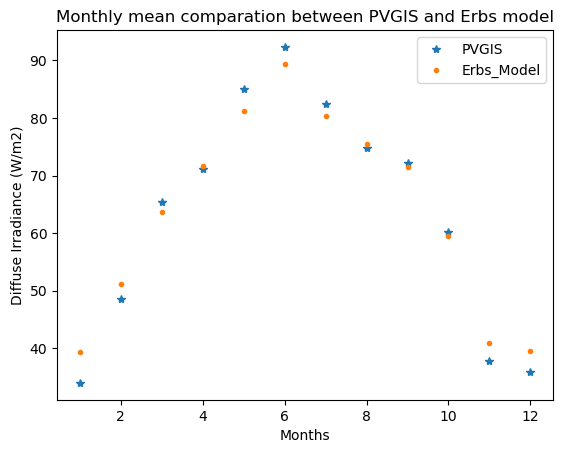

In [9]:
# Now it will be compare the database diffuse with the diffuse calculated by the decomposition model.
# Here monthly average values.
import numpy as np
# importing the required module
import matplotlib.pyplot as plt
  
# x axis values
x = Location_TMY_df['dhi'].resample('M').mean().index.month
# corresponding y axis values
y = estimated_radiation['dhi'].resample('M').mean()
y2 = Location_TMY_df['dhi'].resample('M').mean()
  
# plotting the points 
plt.plot(x, y2,'*', label = 'PVGIS')
plt.plot(x, y,'.', label = 'Erbs_Model')
  
# naming the x axis
plt.xlabel('Months')
# naming the y axis
plt.ylabel('Diffuse Irradiance (W/m2)')
  
# giving a title to my graph
plt.title('Monthly mean comparation between PVGIS and Erbs model')
  
# function to show the plot
plt.legend()
plt.show()

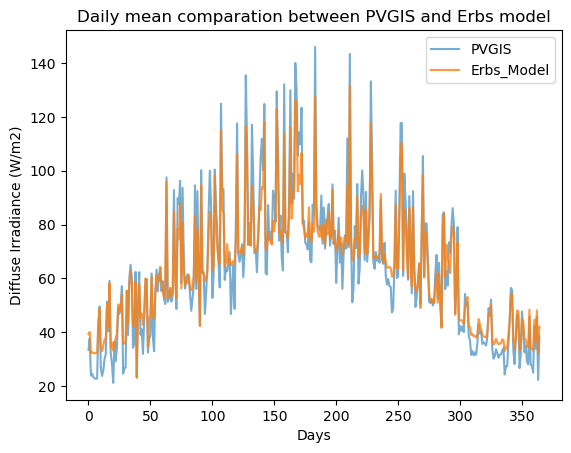

In [10]:
# Now it will be compare the database diffuse with the diffuse calculated by the decomposition model.
# Here mean hourly values.
# x axis values

x = list(range(0,365))
# corresponding y axis values
y = estimated_radiation['dhi'].resample('D').mean()
y2 = Location_TMY_df['dhi'].resample('D').mean()
  
# plotting the points 
plt.plot(x, y2,label = 'PVGIS',alpha=0.6)
plt.plot(x, y,label = 'Erbs_Model', alpha = 0.8)
  
# naming the x axis
plt.xlabel('Days')
# naming the y axis
plt.ylabel('Diffuse Irradiance (W/m2)')
  
# giving a title to my graph
plt.title('Daily mean comparation between PVGIS and Erbs model')
  
# function to show the plot
plt.legend()
plt.show()

# 3. Module mounting and tracking

In [11]:
# We have different type of mounting, it can be watched with the following function
TEMPERATURE_MODEL_PARAMETERS = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS


In [12]:
# It will be chose the open_rack_glass_glass mounting and then it will be save the temperature parameters of this
temperature_model_parameters_selected = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
 

In [13]:
surface_tilt = 20
surface_azimuth = 180
solar_zenith = solpos['zenith']
solar_azimuth = solpos['azimuth']
dni = Location_TMY_df['dni']
ghi = Location_TMY_df['ghi'] #ghi known
dhi = Location_TMY_df['dhi']

In [14]:
poa_irradiance = pvlib.irradiance.get_total_irradiance(surface_tilt, surface_azimuth, solar_zenith, solar_azimuth, dni, ghi, dhi, dni_extra=None, airmass=None, albedo=0.25, surface_type=None, model='isotropic', model_perez='allsitescomposite1990')

## 3.1. BONUS

surface_tilt: 10 2082131.3440504565 W/m2
surface_tilt: 20 2164988.4265547087 W/m2
surface_tilt: 30 2198698.2235475834 W/m2
surface_tilt: 40 2182634.8427422834 W/m2
surface_tilt: 50 2116796.601354826 W/m2


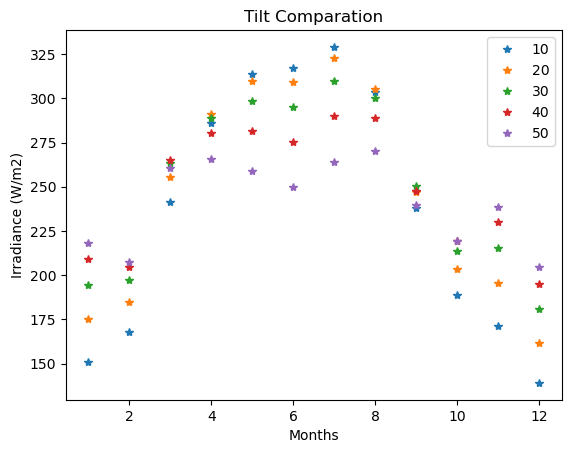

In [15]:
tilt_angle = [10,20,30,40,50]
for i in tilt_angle:
    surface_tilt = i
    poa_irradiance = pvlib.irradiance.get_total_irradiance(surface_tilt, surface_azimuth, solar_zenith, solar_azimuth, dni, ghi, dhi, dni_extra=None, airmass=None, albedo=0.25, surface_type=None, model='isotropic', model_perez='allsitescomposite1990')
    x = list(range(1,13)) 
    y = poa_irradiance['poa_global'].resample('M').mean()
    plt.plot(x,y,'*',label = i)
    plt.legend()

    print("surface_tilt:", i , poa_irradiance['poa_global'].sum(),"W/m2")
   
# naming the x axis
plt.xlabel('Months')
# naming the y axis
plt.ylabel('Irradiance (W/m2)')

# giving a title to my graph
plt.title('Tilt Comparation')
  
# function to show the plot
plt.show()


In [16]:
tilt_angle = [30,31,32,33,34,35]
optimun_list = []
for i in tilt_angle:
    surface_tilt = i
    poa_irradiance = pvlib.irradiance.get_total_irradiance(surface_tilt, surface_azimuth, solar_zenith, solar_azimuth, dni, ghi, dhi, dni_extra=None, airmass=None, albedo=0.25, surface_type=None, model='isotropic', model_perez='allsitescomposite1990')
    x = poa_irradiance['poa_global'].sum()
    optimun_list.append(x)
    print('Para el ángulo', i,'la irradiancia sería:',x)
print('El máximo es:', max(optimun_list))
    

Para el ángulo 30 la irradiancia sería: 2198698.2235475834
Para el ángulo 31 la irradiancia sería: 2199388.702307615
Para el ángulo 32 la irradiancia sería: 2199568.197073449
Para el ángulo 33 la irradiancia sería: 2199236.65316924
Para el ángulo 34 la irradiancia sería: 2198394.171586472
Para el ángulo 35 la irradiancia sería: 2197041.008953198
El máximo es: 2199568.197073449


It will be selected 32º for tilt_surface.

# 4. POA Irradiance

In [17]:
surface_tilt = 32
poa_irradiance = pvlib.irradiance.get_total_irradiance(surface_tilt, surface_azimuth, solar_zenith, solar_azimuth, dni, ghi, dhi, dni_extra=None, airmass=None, albedo=0.25, surface_type=None, model='isotropic', model_perez='allsitescomposite1990')


In [18]:
poa_irradiance

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2022-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0
2022-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0
2022-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0
2022-01-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0
2022-01-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2022-12-31 19:00:00+00:00,0.0,0.0,0.0,0.0,0.0
2022-12-31 20:00:00+00:00,0.0,0.0,0.0,0.0,0.0
2022-12-31 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0
2022-12-31 22:00:00+00:00,0.0,0.0,0.0,0.0,0.0


In [19]:
# Anual total global irradiance in the plane-of-array.
poa_irradiance['poa_global'].sum()

2199568.197073449

# 5.Define a PV Module

## 5.1 Plot IV Curve

In [20]:
CECMODS = pvlib.pvsystem.retrieve_sam('CECMod')

In [21]:
from IPython.display import HTML
result = CECMODS.to_html()
html = CECMODS.to_html()
# display(results)

In [22]:
Module_selected = CECMODS['Trina_Solar_TSM_385DE14H_II_']

In [23]:
Module_selected

Technology            Mono-c-Si
Bifacial                      0
STC                     385.361
PTC                       359.4
A_c                        1.96
Length                      NaN
Width                       NaN
N_s                          48
I_sc_ref                  10.03
V_oc_ref                   48.5
I_mp_ref                   9.61
V_mp_ref                   40.1
alpha_sc               0.004514
beta_oc                -0.13289
T_NOCT                     44.4
a_ref                  1.824077
I_L_ref               10.353805
I_o_ref                     0.0
R_s                    0.287986
R_sh_ref             149.653122
Adjust                 7.622264
gamma_r                  -0.353
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Trina_Solar_TSM_385DE14H_II_, dtype: object

In [24]:
from pvlib import pvsystem

In [25]:
def plot_iv(pv_module, irr, t_cell, ax, title, label):
    cecparams = pvlib.pvsystem.calcparams_cec(
        effective_irradiance=irr,
        temp_cell=t_cell,
        alpha_sc=pv_module.alpha_sc,
        a_ref=pv_module.a_ref,
        I_L_ref=pv_module.I_L_ref,
        I_o_ref=pv_module.I_o_ref,
        R_sh_ref=pv_module.R_sh_ref,
        R_s=pv_module.R_s,
        Adjust=pv_module.Adjust,
        EgRef=1.121,
        dEgdT=-0.0002677)
    
    IL, I0, Rs, Rsh, nNsVth = cecparams
    
    curve_info = pvlib.pvsystem.singlediode(
    photocurrent=IL,
    saturation_current=I0,
    resistance_series=Rs,
    resistance_shunt=Rsh,
    nNsVth=nNsVth,
    ivcurve_pnts=101,
    method='lambertw')
    
    ax.plot(curve_info['v'], curve_info['i'], label=label)
    ax.plot(curve_info['v_mp'], curve_info['i_mp'], ls='', marker='o', c='black')
    ax.set_title(title)
    ax.set_xlabel('Module voltage [V]')
    ax.set_ylabel('Module current [A]')
    ax.legend()

In [26]:
# STC Conditions
E0 = 1000
T0 = 25

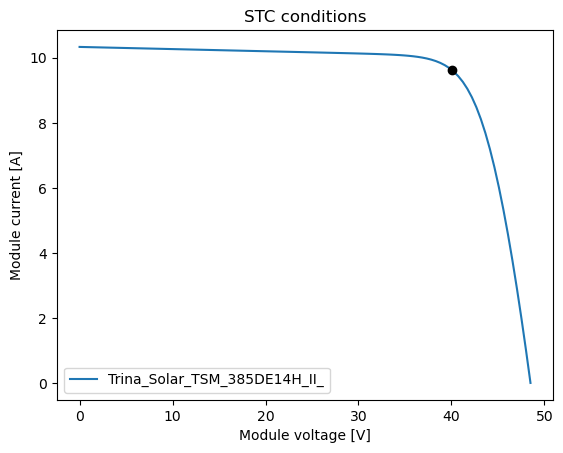

In [27]:
f, ax = plt.subplots()
plot_iv(pv_module=Module_selected, irr=E0, t_cell=T0, ax=ax, title='STC conditions', label='Trina_Solar_TSM_385DE14H_II_')


## 5.2. From manufacturer's datasheet

JA Solar JAM72S20 450 W
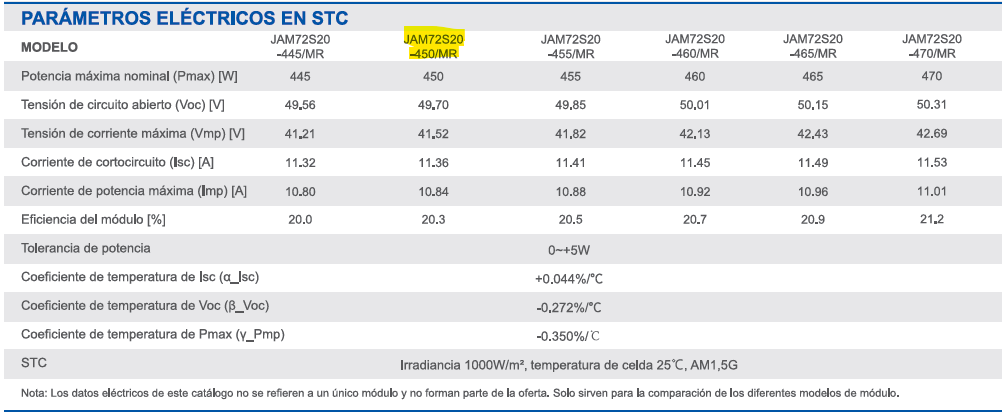


In [28]:
v_mp = 41.52 #V
i_mp = 10.84 #A
v_oc = 49.70 #V
i_sc = 11.36 #A
alpha_sc = (i_sc*-0.044)/(100)
beta_voc = (v_oc*-0.272)/(100)
cells_in_series = 48

In [29]:
sdm_params = pvlib.ivtools.sdm.fit_desoto(
    v_mp,
    i_mp,
    v_oc,
    i_sc,
    alpha_sc,
    beta_voc,
    cells_in_series,
    EgRef=1.121,
    dEgdT=- 0.0002677,
    temp_ref=25,
    irrad_ref=1000,
    )

In [30]:
JA_Solar_params = sdm_params[0]
JA_df = pd.Series(JA_Solar_params)
JA_df

I_L_ref      1.136146e+01
I_o_ref      1.006396e-11
R_s          2.381704e-01
R_sh_ref     1.850252e+03
a_ref        1.790996e+00
alpha_sc    -4.998400e-03
EgRef        1.121000e+00
dEgdT       -2.677000e-04
irrad_ref    1.000000e+03
temp_ref     2.500000e+01
dtype: float64

In [31]:
def plot_iv_Soto(pv_module, irr, t_cell, ax, title, label):
    cecparams_soto = pvsystem.calcparams_desoto(
        1000,
        25,
        alpha_sc = JA_df.alpha_sc,
        a_ref = JA_df.a_ref, # Ns*n*Vt
        I_L_ref = JA_df.I_L_ref,
        I_o_ref = JA_df.I_o_ref,
        R_sh_ref = JA_df.R_sh_ref,
        R_s = JA_df.R_s,
        EgRef=1.121,
        dEgdT=- 0.0002677,
        irrad_ref=1000, #G(STC)
        temp_ref=25 #Tcell(STC)
)
    
    IL, I0, Rs, Rsh, nNsVth = cecparams_soto
    
    curve_info_soto = pvlib.pvsystem.singlediode(
    photocurrent=IL,
    saturation_current=I0,
    resistance_series=Rs,
    resistance_shunt=Rsh,
    nNsVth=nNsVth,
    ivcurve_pnts=100,
    method='lambertw')
    
    ax.plot(curve_info_soto['v'], curve_info_soto['i'], label=label)
    ax.plot(curve_info_soto['v_mp'], curve_info_soto['i_mp'], ls='', marker='o', c='black')
    ax.set_title(title)
    ax.set_xlabel('Module voltage [V]')
    ax.set_ylabel('Module current [A]')
    ax.legend()
    return curve_info_soto, cecparams_soto

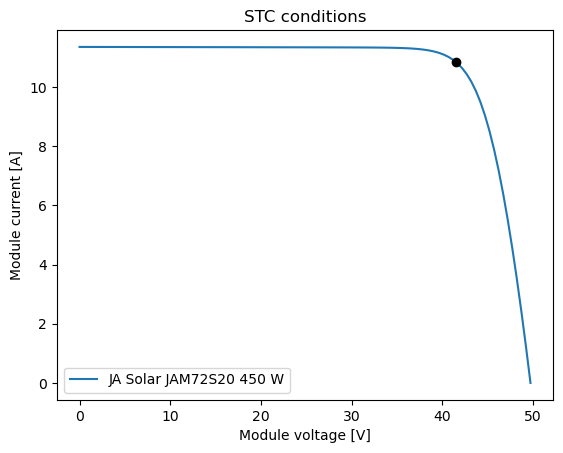

In [32]:
f, ax = plt.subplots()
a,b = plot_iv_Soto(pv_module=JA_df, irr=E0, t_cell=T0, ax=ax, title='STC conditions', label='JA Solar JAM72S20 450 W')


# 6. Estimate Cell Temperature

In [33]:
# It will be chosen the open_rack_glass_glass mounting and then it will be save the temperature parameters of this
temperature_model_parameters_selected = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']

In [34]:
temperature_model_parameters_selected

{'a': -3.56, 'b': -0.075, 'deltaT': 3}

In [35]:
Location_TMY_df.head(5)

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
2022-01-01 00:00:00+00:00,14.85,97.13,0.0,0.0,0.0,328.37,5.96,278.0,102151.0
2022-01-01 01:00:00+00:00,14.50,97.85,0.0,0.0,0.0,332.70,6.62,276.0,102104.0
2022-01-01 02:00:00+00:00,14.15,98.57,0.0,0.0,0.0,337.03,7.29,275.0,102057.0
2022-01-01 03:00:00+00:00,13.80,99.30,0.0,0.0,0.0,341.36,7.95,274.0,102054.0
2022-01-01 04:00:00+00:00,13.46,100.00,0.0,0.0,0.0,345.69,8.61,274.0,102051.0


In [36]:
cell_temp = pvlib.temperature.sapm_cell(
poa_global = poa_irradiance['poa_global'], #plane-of-array global irradiance [W/m^2]
temp_air = Location_TMY_df['temp_air'], #air temperature [°C]
wind_speed = Location_TMY_df['wind_speed'], #Wind speed at a height of 10 meters [m/s]
a = temperature_model_parameters_selected['a'], # empirical parameter a
b = temperature_model_parameters_selected['b'], # empirical parameter b
deltaT = temperature_model_parameters_selected['deltaT'], # empirical parameter ΔT
irrad_ref=1000 # reference irradiance Gref of 1000 Wm-2
)

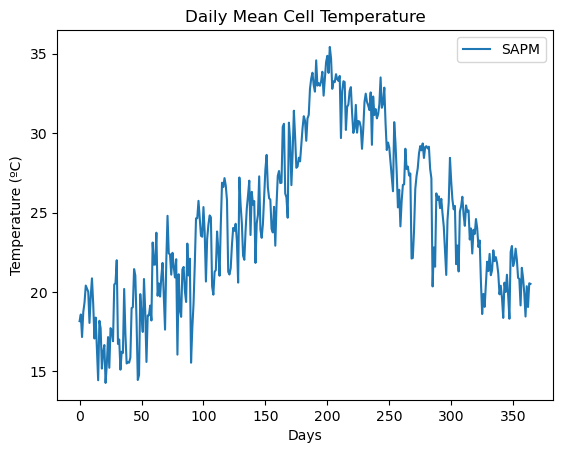

In [37]:
# Now it will be compare the database diffuse with the diffuse calculated by the decomposition model.
# Here mean hourly values.
# x axis values

x = list(range(0,365))
# corresponding y axis values
y = cell_temp.resample('D').mean()
  
# plotting the points 
plt.plot(x, y,label = 'SAPM')

  
# naming the x axis
plt.xlabel('Days')
# naming the y axis
plt.ylabel('Temperature (ºC)')
  
# giving a title to my graph
plt.title('Daily Mean Cell Temperature')
  
# function to show the plot
plt.legend()
plt.show()

## 6.1. OPTIONAL BONUS: COMPARE 2 DIFERENT MODELS

In [38]:
temperature_model_parameters_selected

{'a': -3.56, 'b': -0.075, 'deltaT': 3}

In [39]:
cell_temp_variation = pvlib.temperature.pvsyst_cell(
poa_global = poa_irradiance['poa_global'], #plane-of-array global irradiance [W/m^2]
temp_air = Location_TMY_df['temp_air'], #air temperature [°C]
wind_speed = Location_TMY_df['wind_speed'],#Wind speed in m/s d.
u_c=29.0, #Combined heat loss factor coefficient. Default free-standing
u_v=0.0, #Wind heat dissipation. Neglected by default to reduce uncertainty.
eta_m=0.23, #η module efficiency, we are going to take JA Solar
alpha_absorption=0.9 # α absorption coefficient
)

C:\Users\marti\miniconda3\lib\site-packages\pvlib\temperature.py:382: pvlibDeprecationWarning: 
eta_m overwriting module_efficiency
  warn_deprecated(


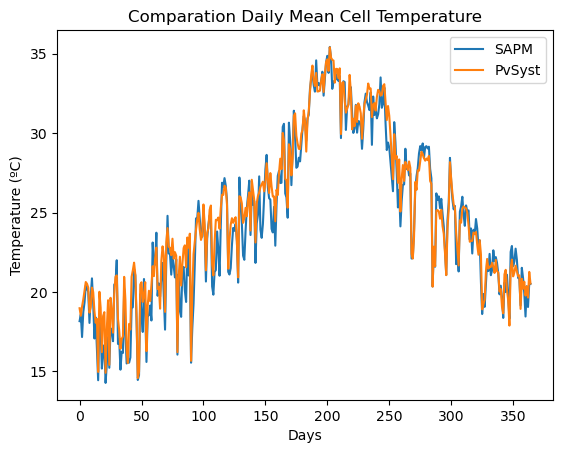

In [40]:
# Now it will be compare the database diffuse with the diffuse calculated by the decomposition model.
# Here mean hourly values.
# x axis values

x = list(range(0,365))
# corresponding y axis values
y = cell_temp.resample('D').mean()
y2 = cell_temp_variation.resample('D').mean()
  
# plotting the points 
plt.plot(x, y,label = 'SAPM')
plt.plot(x, y2,label = 'PvSyst')

  
# naming the x axis
plt.xlabel('Days')
# naming the y axis
plt.ylabel('Temperature (ºC)')
  
# giving a title to my graph
plt.title('Comparation Daily Mean Cell Temperature')
  
# function to show the plot
plt.legend()
plt.show()

# 7. Estimate IAM and Soiling

In [41]:
# First it will be calculated AOI
AOI = pvlib.irradiance.aoi(surface_tilt = surface_tilt, 
                     surface_azimuth = surface_azimuth, 
                     solar_zenith = solar_zenith, 
                     solar_azimuth = solar_azimuth)

In [42]:
 ### IAM loss factor
IAM = pvlib.iam.ashrae(aoi = AOI, 
                 b=0.05)
effective_irradiance_1 = poa_irradiance['poa_direct']*IAM + poa_irradiance['poa_diffuse']

 ### Soiling loss factor
rain = pd.Series(0, index=Location_TMY_df.index)
rain['2022-01-01'] = 1 # mm
rain['2022-02-01'] = 1 # mm
rain['2022-06-01'] = 1 # mm
effective_irradiance_2 = effective_irradiance_1 * (1 - pvlib.soiling.kimber(rainfall=rain))


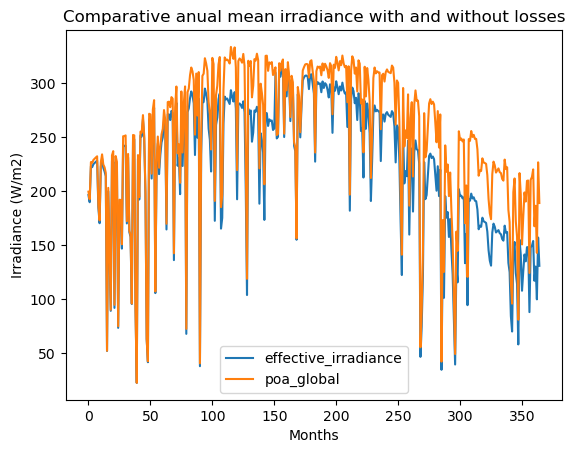

In [43]:
# Now it will be compare the database diffuse with the diffuse calculated by the decomposition model.
# Here mean hourly values.
# x axis values
x = list(range(0,365))
y = effective_irradiance_2.resample('D').mean()
y2 = poa_irradiance['poa_global'].resample('D').mean()
# corresponding y axis values
plt.plot(x, y,label = 'effective_irradiance')
plt.plot(x, y2,label = 'poa_global')
# plotting the points 
  
# naming the x axis
plt.xlabel('Months')
# naming the y axis
plt.ylabel('Irradiance (W/m2)')
  
# giving a title to my graph
plt.title('Comparative anual mean irradiance with and without losses')
  
# function to show the plot
plt.legend()
plt.show()

## 7.1. BONUS KIMBER SOILING

In [44]:
# In the TMY from PVGIS we don't have rainfall data. We take it from (https://climate.onebuilding.org/WMO_Region_6_Europe/ESP_Spain/index.html) 
# in a EPW file
rain_kimber = pvlib.iotools.read_epw("Granada3.epw", coerce_year=2022) #Read EPW file for 2015 for example.

In [45]:
rain_kimber[0].head() #Here we only need the column "precipitable water"

,year,month,day,hour,minute,data_source_unct,temp_air,temp_dew,relative_humidity,atmospheric_pressure,...,ceiling_height,present_weather_observation,present_weather_codes,precipitable_water,aerosol_optical_depth,snow_depth,days_since_last_snowfall,albedo,liquid_precipitation_depth,liquid_precipitation_quantity
2022-01-01 00:00:00+01:00,2022,1,1,1,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9,0.8,-6.3,56,92918,...,77777,9,999999999,4,0.085,0,88,0.200,0.0,0.0
2022-01-01 01:00:00+01:00,2022,1,1,2,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9,0.1,-6.6,56,92900,...,77777,9,999999999,4,0.085,0,88,0.200,0.0,0.0
2022-01-01 02:00:00+01:00,2022,1,1,3,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9,-0.3,-6.9,57,92886,...,77777,9,999999999,4,0.085,0,88,0.220,0.0,0.0
2022-01-01 03:00:00+01:00,2022,1,1,4,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9,-0.5,-7.0,58,92881,...,77777,9,999999999,4,0.085,0,88,0.233,0.0,0.0
2022-01-01 04:00:00+01:00,2022,1,1,5,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9,-0.2,-6.8,57,92891,...,77777,9,999999999,4,0.085,0,88,0.213,0.0,0.0


In [46]:
data = {'precipitable_water': rain_kimber[0]['precipitable_water']}
rain_fall_df = pd.DataFrame(data, rain_kimber[0].index) #Now we have precipitable water data
rain_fall_df['precipitable_water'] = rain_fall_df['precipitable_water'] - 15

In [47]:
soiling_kimber = pvlib.soiling.kimber(rainfall = rain_fall_df['precipitable_water'],
                     cleaning_threshold=6, 
                     soiling_loss_rate=0.0015, 
                     grace_period=14, 
                     max_soiling=0.3, 
                     manual_wash_dates=None, 
                     initial_soiling=0, 
                     rain_accum_period=24)

<AxesSubplot: >

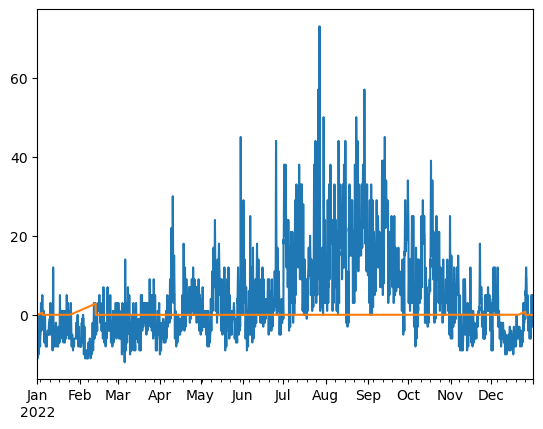

In [48]:
rain_fall_df['precipitable_water'].plot()
(soiling_kimber*100).plot()

In [49]:
effective_irradiance_3 = effective_irradiance_1 * (1-0.02) #Como el resultado de los datos meteorológicos no es muy fiable vamos a seguir
# suponiendo unas pérdidas por soiling del 2%.

# 8. Maximun Power

In [50]:
Module_selected #Selected Module

Technology            Mono-c-Si
Bifacial                      0
STC                     385.361
PTC                       359.4
A_c                        1.96
Length                      NaN
Width                       NaN
N_s                          48
I_sc_ref                  10.03
V_oc_ref                   48.5
I_mp_ref                   9.61
V_mp_ref                   40.1
alpha_sc               0.004514
beta_oc                -0.13289
T_NOCT                     44.4
a_ref                  1.824077
I_L_ref               10.353805
I_o_ref                     0.0
R_s                    0.287986
R_sh_ref             149.653122
Adjust                 7.622264
gamma_r                  -0.353
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Trina_Solar_TSM_385DE14H_II_, dtype: object

In [51]:
# calculate IV Parameters
iv_params = pvlib.pvsystem.calcparams_desoto(
        effective_irradiance=effective_irradiance_3,
        temp_cell=cell_temp,
        alpha_sc=Module_selected.alpha_sc,
        a_ref=Module_selected.a_ref,
        I_L_ref=Module_selected.I_L_ref,
        I_o_ref=Module_selected.I_o_ref,
        R_sh_ref=Module_selected.R_sh_ref,
        R_s=Module_selected.R_s)
IL, I0, Rs, Rsh, nNsVth = iv_params

# get the IV curve info using single diode model
# max_power_point() is a faster version of single_diode() that doesn't compute the full IV curve
power_module = pvlib.pvsystem.max_power_point(*iv_params, method='newton')

Text(0, 0.5, 'Production [Wh]')

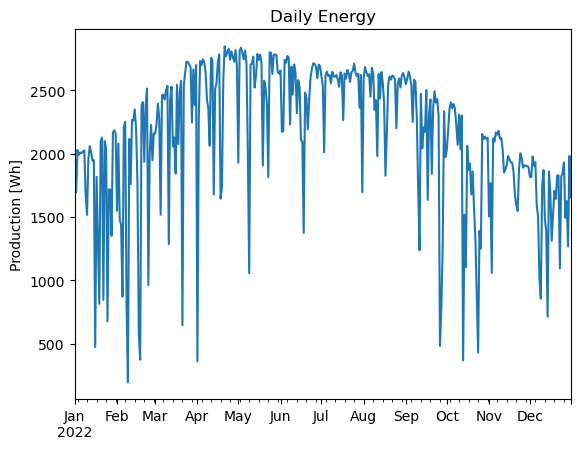

In [52]:
# plot energy annual DC production for 1 PV module
power_module['p_mp'].resample('D').sum().plot(title='Daily Energy')
plt.ylabel('Production [Wh]')

<AxesSubplot: >

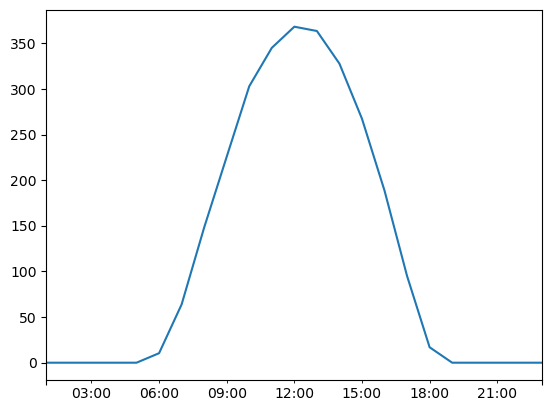

In [53]:
power_module['p_mp']['2022-04-16 00:09:00+00:00':'2022-04-16 23:09:00+00:00'].plot() #Hourly energy delivered by the module on my birthday April 16.

# 10. Central Inverter Selection

In [54]:
# from IPython.display import HTML
# result = inverters.to_html()
# print(result)
# html = inverters.to_html()
  
# write html to file
# text_file = open("index.html", "w")
# text_file.write(html)
# text_file.close()

In [55]:
# Selection of an inverter whose maximum output power matches the nominal power of my power plant (12kW)
inverters = pvlib.pvsystem.retrieve_sam('CECInverter')
inverter_12K = inverters['Advanced_Energy_Industries__AE_3TL_12_10__480V_']

In [56]:
inverter_12K

Vac                          480
Pso                     63.25692
Paco                     12000.0
Pdco                12274.302734
Vdco                       720.0
C0                          -0.0
C1                     -0.000012
C2                     -0.000531
C3                     -0.005697
Pnt                          3.6
Vdcmax                     900.0
Idcmax                 17.047643
Mppt_low                   450.0
Mppt_high                  900.0
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: Advanced_Energy_Industries__AE_3TL_12_10__480V_, dtype: object

# 11. DC to AC Ratio

In [57]:
# ratio DC/AC
dc_ac_ratio = 1.3

# 12. Dimension of the PV Array

In [58]:
Location_TMY_df

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
2022-01-01 00:00:00+00:00,14.85,97.13,0.0,0.0,0.0,328.37,5.96,278.0,102151.0
2022-01-01 01:00:00+00:00,14.50,97.85,0.0,0.0,0.0,332.70,6.62,276.0,102104.0
2022-01-01 02:00:00+00:00,14.15,98.57,0.0,0.0,0.0,337.03,7.29,275.0,102057.0
2022-01-01 03:00:00+00:00,13.80,99.30,0.0,0.0,0.0,341.36,7.95,274.0,102054.0
2022-01-01 04:00:00+00:00,13.46,100.00,0.0,0.0,0.0,345.69,8.61,274.0,102051.0
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,16.58,93.52,0.0,0.0,0.0,306.73,2.65,264.0,102504.0
2022-12-31 20:00:00+00:00,16.23,94.24,0.0,0.0,0.0,311.06,3.32,263.0,102517.0
2022-12-31 21:00:00+00:00,15.89,94.97,0.0,0.0,0.0,315.39,3.98,257.0,102497.0
2022-12-31 22:00:00+00:00,15.54,95.69,0.0,0.0,0.0,319.72,4.64,251.0,102477.0


In [59]:
Min_Temp = 25 
rango = list(range(0,len(Location_TMY_df)))

In [60]:
for i in rango:
    ghi_needed = Location_TMY_df['ghi'][i]
    temp_air_needed = Location_TMY_df['temp_air'][i]
    if (ghi_needed > 0) & (temp_air_needed < Min_Temp):
            Min_Temp =  Location_TMY_df['temp_air'][i] 
print(Min_Temp)

10.62


In [61]:
Module_selected

Technology            Mono-c-Si
Bifacial                      0
STC                     385.361
PTC                       359.4
A_c                        1.96
Length                      NaN
Width                       NaN
N_s                          48
I_sc_ref                  10.03
V_oc_ref                   48.5
I_mp_ref                   9.61
V_mp_ref                   40.1
alpha_sc               0.004514
beta_oc                -0.13289
T_NOCT                     44.4
a_ref                  1.824077
I_L_ref               10.353805
I_o_ref                     0.0
R_s                    0.287986
R_sh_ref             149.653122
Adjust                 7.622264
gamma_r                  -0.353
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Trina_Solar_TSM_385DE14H_II_, dtype: object

In [62]:
# modules per string: max voltage
temp_ref = 25  # °C
max_voc_module = Module_selected.V_oc_ref + Module_selected.beta_oc * (Min_Temp - temp_ref)
modules_per_string = int(inverter_12K['Vdcmax'] / max_voc_module)

# strings per inverter
power_string = Module_selected.STC * modules_per_string
strings_per_inverter = int(dc_ac_ratio * inverter_12K['Paco'] / power_string)

dc_capacity = strings_per_inverter * power_string

dc_output = power_module['p_mp'] * modules_per_string * strings_per_inverter

print(f"DC capacity={dc_capacity:,.0f} W.", f"AC capacity (inverter nominal power)={inverter_12K['Paco']:,.0f} W")
print(f"Modules per string={modules_per_string:,.0f}.", f"Strings per inverter={strings_per_inverter:,.0f}")

DC capacity=13,102 W. AC capacity (inverter nominal power)=12,000 W
Modules per string=17. Strings per inverter=2


# 9. DC Wiring losses and mismath losses

In [63]:
effective_irradiance_3.sum()

2123019.4576032665

In [64]:
### Spectral mismatch loss factor
spectral_mismatch_loss = 2/100
dc_output_1 = dc_output * (1-spectral_mismatch_loss)

In [65]:
# Para calcular las pérdidas DC vamos a elegir ya un predimensionado del sistema
# como tenemos 12 kW de pottencia nóminal suponemos 40 módulos de 385 W y 5 string de 8

In [66]:
print('v_mp:', Module_selected['V_mp_ref'])
print('i_mp:',  Module_selected['I_mp_ref'])
dc_ohmic_percent = 1.5 # Supones un 1.5%
print('Suponemos una pérdida de:', dc_ohmic_percent ,'%')

v_mp: 40.1
i_mp: 9.61
Suponemos una pérdida de: 1.5 %


In [67]:
resistance = pvlib.pvsystem.dc_ohms_from_percent(Module_selected['V_mp_ref'], Module_selected['I_mp_ref'], dc_ohmic_percent, modules_per_string=8, strings=5)   
print('La resistencia equivalente sería:', resistance)

La resistencia equivalente sería: 0.10014568158168576


In [68]:
power_DC_loss = pvlib.pvsystem.dc_ohmic_losses(resistance, power_module['i_mp'])

In [69]:
dc_output_2 = dc_output_1 - power_DC_loss

# 13. AC hourly output

In [70]:
# DC & AC output
ac_output = pvlib.inverter.sandia(
    v_dc=power_module['v_mp'] * modules_per_string,
    p_dc=dc_output_2,
    inverter=inverter_12K)

print(f"DC output={dc_output_2.sum()/1000:,.0f} kWh, AC output={ac_output.sum()/1000:,.0f} kWh")

DC output=26,239 kWh, AC output=25,519 kWh


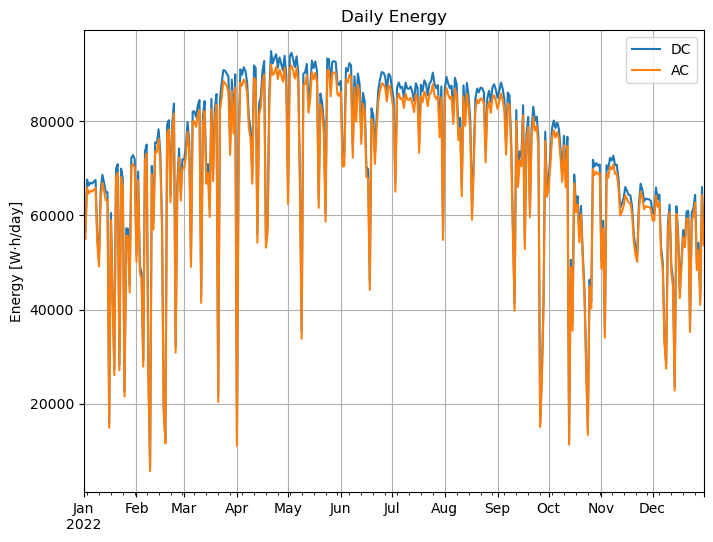

In [71]:
# Plot annual DC & AC output
ax = dc_output_2.resample('D').sum().plot(figsize=(8, 6), label='DC', title='Daily Energy')
ac_output.resample('D').sum().plot(ax=ax, label='AC')
plt.ylabel('Energy [W·h/day]')
plt.legend()
plt.grid()

In [72]:
print(f"Inverter losses={1 - (ac_output.sum() / dc_output_2.sum()):.2%}")

Inverter losses=2.74%


# 14. Calculate DC array yield (YA), AC final yield (YF) and reference yield (YR), and then obtain the resulting performance ratio (PR).

### Ya

In [73]:
Pnom = (Module_selected['STC']*34)/1000 #kWp
Eg_FV = dc_output_2/1000 #kWh

In [74]:
Ya = Eg_FV/Pnom

In [75]:
Ya.sum()

2002.6083596481685

### 14.2 Yf

In [76]:
E_FV = ac_output/1000 #kWh

In [77]:
Yf = E_FV/Pnom

In [78]:
Yf.sum()

1947.7149474172454

### Yr

In [79]:
G_inc = poa_irradiance['poa_global']/1000 #kWh/m2
G_ref = 1 #kW/m2

In [80]:
Yr = G_inc/G_ref

In [81]:
Yr.sum()

2199.5681970734486

### PR

In [82]:
PR = Yf.sum()/Yr.sum()
PR_h = Yf/Yr
PR_h_c = PR_h.replace(-np.inf, 0.0)
print('El rendimiento carácteristico ANUAL del sistema es:', PR)
print('El rendimiento carácteristico MEDIO del sistema es:', PR_h_c.mean())

El rendimiento carácteristico ANUAL del sistema es: 0.8854987765365507
El rendimiento carácteristico MEDIO del sistema es: 0.41205798231133456


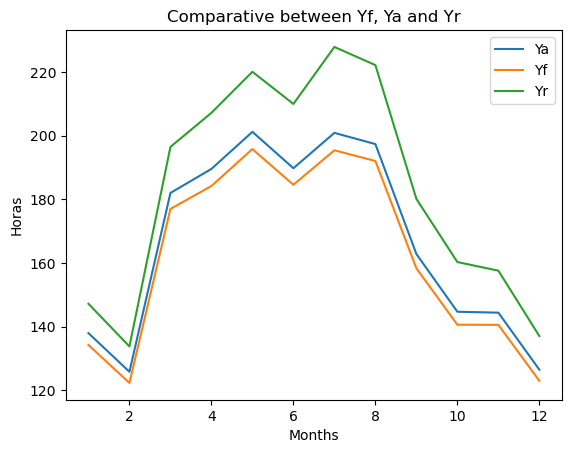

In [83]:
months = list(range(1,13))
x = months
y = Ya.resample('M').sum()
y2 = Yf.resample('M').sum()
y3 = Yr.resample('M').sum()
# y4 = PR_h_c.resample('M').mean()
# corresponding y axis values
plt.plot(x, y,label = 'Ya')
plt.plot(x, y2,label = 'Yf')
plt.plot(x, y3,label = 'Yr')
# plt.plot(x, y4,label = 'PR_h_c')
# plotting the points 
  
# naming the x axis
plt.xlabel('Months')
# naming the y axis
plt.ylabel('Horas')
  
# giving a title to my graph
plt.title('Comparative between Yf, Ya and Yr')
  
# function to show the plot
plt.legend()
plt.show()

# BONUS

In [84]:
sankey1 = Location_TMY_df['ghi'].sum()/1000 #Horizontal Global Irradiation
sankey1

1953.98075

In [247]:
sankey2 = poa_irradiance['poa_global'].sum()/1000 - sankey1 #POA Irradiation
sankey2

245.58744707344908

In [249]:
sankey3 = poa_irradiance['poa_global'].sum()/1000 - effective_irradiance_1.sum()/1000  #IAM losses
sankey3

33.22181176399317

In [250]:
sankey4 = effective_irradiance_1.sum()/1000 - effective_irradiance_3.sum()/1000 #Soiling losses
sankey4

43.32692770618951

In [252]:
sankey5 = sankey1 +  sankey2 - sankey3 - sankey4 #la energía que queda después de las pérdidas
sankey5

2123.0194576032663

In [240]:
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey

[namespace(patch=<matplotlib.patches.PathPatch at 0x1c7e31b2650>,
           flows=array([ 245.58744707,    0.        , 1953.98075   ,  -33.22181176,
                         -43.32692771, 2123.0194576 ]),
           angles=[3, None, 0, 3, 3, 0],
           tips=array([[ -123.29372354,  2058.35765921],
                       [    0.        ,     0.        ],
                       [  573.75481625,   938.71600526],
                       [   60.68783359,    -9.01082002],
                       [   22.16346385,   -56.57734725],
                       [  644.52497486, -1099.78409854]]),
           text=Text(0, 0, ''),
           texts=[Text(-123.29372353672454, 2058.5076592078076, 'Global Horizontal Irradiation\n245.587'),
                  Text(0.0, 0.0, ''),
                  Text(573.6048162528033, 938.7160052649084, 'POA Irradiation\n1953.98'),
                  Text(60.687833588186095, -9.160820016940997, 'IAM losses\n33.2218'),
                  Text(22.163463853094754, -56.72734725

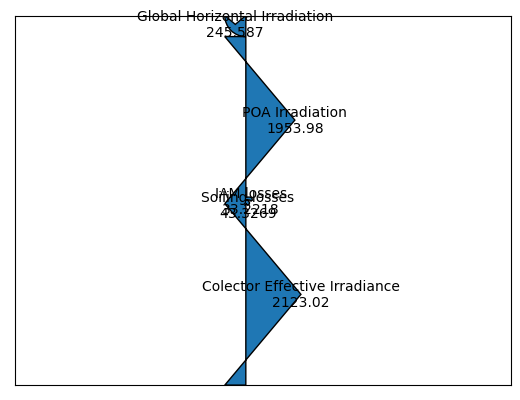

In [284]:
Sankey(flows=[ sankey2,0,sankey1,-sankey3,-sankey4, sankey5], 
       labels=['Global Horizontal Irradiation',"",'POA Irradiation', 'IAM losses', 'Soiling losses', 'Colector Effective Irradiance'], 
       orientations=[1,1,0, -1, -1, 0],
       pathlengths=[0.1,0.1,0.1, 0.1, 0.1, 0.1]).finish()


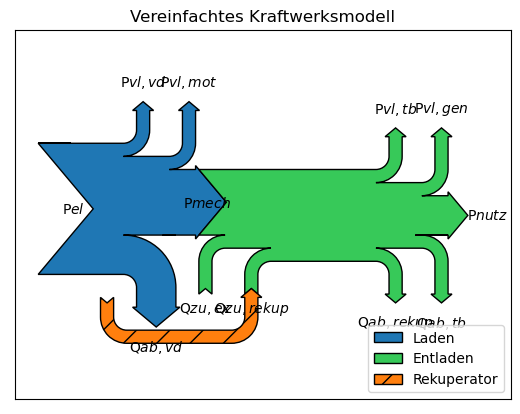

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[],
                     title="Vereinfachtes Kraftwerksmodell")
sankey = Sankey(ax=ax, unit=None)
sankey.add(flows=[1.0, -0.3, -0.1, -0.1, -0.5],
           labels=['P$el$', 'Q$ab,vd$', 'P$vl,vd$', 'P$vl,mot$', ''],
           label='Laden',
           orientations=[0, -1, 1, 1, 0])
sankey.add(flows=[0.5, 0.1, 0.1, -0.1, -0.1, -0.1, -0.1, -0.3], fc='#37c959',
           label='Entladen',
           labels=['P$mech$', 'Q$zu,ex$', 'Q$zu,rekup$', 'P$vl,tb$', 'P$vl,gen$',         'Q$ab,tb$', 'Q$ab,rekup$', 'P$nutz$'],
           orientations=[0, -1, -1, 1, 1, -1, -1, 0], prior=0, connect=(4, 0))
sankey.add(flows=[-0.1, 0.1],
           label='Rekuperator',
           #labels=['bla'],
           orientations=[1,1], prior=1, connect=(2, 0))
diagrams = sankey.finish()
diagrams[-1].patch.set_hatch('/')
plt.legend(loc='lower right')
plt.show()